                        Project done by Michela Pirozzi MAT:732531 and Sara Ferioli MAT:733105

# LAB 3

## Goal

* Given the features in the dataset, what is the best combination to have a new contract? 
Was the feature combination the same even before covid?

* Predict number of contracts.
Is the number of contracts predicted for the future in 2019 the same or similar to the actual data given the occurrence of COVID? 

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

## Import data and analysis

In [2]:
# Load the dataset
transformed = pd.read_csv('transformed.csv')
transformed = transformed.drop(labels='Unnamed: 0', axis=1)
transformed

,ETA,mese-anno,ANNO,Codice_ateco,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
0,60,2020-05,2020,97,57,0,1,32470
1,61,2014-09,2014,97,57,0,1,32476
2,29,2017-06,2017,97,57,0,1,32455
3,48,2017-08,2017,97,57,0,1,32450
4,54,2020-01,2020,97,57,0,1,32450
...,...,...,...,...,...,...,...,...
8995150,32,2021-08,2021,47,0,1,0,14264
8995151,28,2013-06,2013,52,0,0,0,15697
8995152,29,2014-07,2014,52,0,0,0,15721
8995153,52,2018-12,2018,52,0,0,0,15697


### Balancing

In [3]:
# Check if the dataset is balanced
transformed["contratto_transformed"].value_counts(normalize=True)

0    0.855403
1    0.144597
Name: contratto_transformed, dtype: float64

We notice that the dataset is not balanced basing on the type of contract

In [4]:
# Count the occurencies of INDETERMINATO's contracts
transformed[transformed["contratto_transformed"]==1].count()

ETA                        1300674
mese-anno                  1300674
ANNO                       1300674
Codice_ateco               1300674
nazionalita_transformed    1300674
contratto_transformed      1300674
genere_transformed         1300674
Output_transformed         1300674
dtype: int64

In [5]:
# Count the occurencies of NON INDETERMINATO's contracts
transformed[transformed["contratto_transformed"]==0].count()

ETA                        7694481
mese-anno                  7694481
ANNO                       7694481
Codice_ateco               7694481
nazionalita_transformed    7694481
contratto_transformed      7694481
genere_transformed         7694481
Output_transformed         7694481
dtype: int64

#### Random Undersampling

We use undersampling instead of oversampling because we care more about the INDETERMINATO's contracts which have less occurencies, even if there are the possibilities to lose some informations.

In [6]:
# Execute the undersampling for the NON INDETERMINATO's contracts
data_0 = transformed[transformed["contratto_transformed"]==0].sample(n=1351972,random_state=16) 
data_1 = transformed[transformed["contratto_transformed"]==1]
balanced = data_0.append(data_1)
balanced

,ETA,mese-anno,ANNO,Codice_ateco,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
1120159,23,2013-04,2013,56,27,0,1,16698
8260960,23,2012-09,2012,56,4,0,0,16796
1386666,28,2010-11,2010,85,27,0,1,26688
7223672,28,2017-07,2017,56,45,0,1,17250
8530295,45,2020-03,2020,1,1,0,0,465
...,...,...,...,...,...,...,...,...
8995121,25,2013-05,2013,56,4,1,1,17236
8995123,23,2016-08,2016,81,4,1,0,25056
8995144,31,2011-02,2011,81,0,1,1,25216
8995146,36,2018-03,2018,25,4,1,0,6732


In [7]:
# Check if the dataset is balanced
balanced["contratto_transformed"].value_counts(normalize=True)

0    0.509669
1    0.490331
Name: contratto_transformed, dtype: float64

## Create the train and test sets

In [8]:
# Create the train and test sets
X = balanced[["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"]].values
y = pd.DataFrame(balanced['Codice_ateco'].copy()).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [9]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
X_train=X_train.astype(np.uint8)
y_train=y_train.astype(np.uint8)

## Decision Tree

### Find the best max_depth

In [ ]:
# Find the max depth neccessary for the Decision tree
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
     dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
     dtree.fit(X_train, y_train)
     pred = dtree.predict(X_test)
     acc_gini.append(accuracy_score(y_test, pred))
     ####
     dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
     dtree.fit(X_train, y_train)
     pred = dtree.predict(X_test)
     acc_entropy.append(accuracy_score(y_test, pred))
     ####
     max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

We notice that the best accuracy is when max_depth is (more or less) equal to 10.

### Execution of Decision Tree

In [10]:
# Method that allow to calculate the decision tree
# syntax:
# X_train: input train dataframe
# y_train: output train dataframe
def dct(X_train, y_train):
    dct = tree.DecisionTreeClassifier()
    
    DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=10,
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                           random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           class_weight=None)
    
    return dct

In [11]:
# Create Decision tree and fit it
dct = dct(X_train, y_train)
dct.fit(X_train, y_train)

DecisionTreeClassifier()

In [12]:
# With the following sintax we will create a .dot file with the code for visualizing th tree
tree.export_graphviz(dct, out_file='tree.dot', feature_names=["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"])

In [ ]:
# Show Decision tree
tree.plot_tree(dct)

KeyboardInterrupt: 

In [ ]:
# Probablistic prediction the values
y_pred_prob = dct.predict_proba(X_test)
y_pred_prob

In [ ]:
# Predict the values
y_pred = dct.predict(X_test)
y_pred

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred))

#### Confusion matrix

In [16]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
y_test=y_test.astype(np.uint8)
y_pred=y_pred.astype(np.uint8)

# Print the confusion matrix
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)

[[  2   3  36 ...   1   2   1]
 [  2   2  31 ...   0   4   0]
 [ 42  15 467 ...   1  11   1]
 ...
 [  5   3  67 ...   2   8   0]
 [  6   0  52 ...   2 151   2]
 [  1   0  28 ...   0  10  15]]


### Best Depth Tree

In [17]:
# Calculate the max depth in the decision tree
max_depth = dct.get_depth()
max_depth

35

In [18]:
# Find the best parameter
max_depth_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                                    scoring=make_scorer(accuracy_score),
                                    param_grid=ParameterGrid({"max_depth":[[max_depth] for max_depth in range(1, max_depth+1)]}),)
max_depth_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x000002B5691184F0>,
             scoring=make_scorer(accuracy_score))

In [19]:
# Show the best parameter
max_depth_grid_search.best_params_

{'max_depth': 13}

In [ ]:
# Show the tree with the parameter found previuosly 
best_max_depth_tree=max_depth_grid_search.best_estimator_
best_max_depth = best_max_depth_tree.get_depth()

plt.figure(figsize=(4,4), dpi=1000)
plot_tree(best_max_depth_tree,
         feature_names=["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"],
          filled=True,)
plt.show()

### Prune the tree

The following parts we were not able to execute because they took too long (we never got an output). 
They are for pruning the tree, a technique used to reduce or avoid overfitting.

#### Pre-Pruning

Pre pruning is nothing but stoping the growth of decision tree on an early stage. 

In [ ]:
# Set parameters and prune the tree
grid_param={"criterion":["gini","entropy"],
             "splitter":["best","random"],
             "max_depth":range(2,50,1),
             "min_samples_leaf":range(1,15,1),
             "min_samples_split":range(2,20,1) 
            }
grid_search=GridSearchCV(estimator=dct,param_grid=grid_param,cv=5,n_jobs=-1)
grid_search.fit(X_train,y_train)

In [ ]:
# Print the best parameters
print(grid_search.best_params_)

In [ ]:
# Show the tree
clf=DecisionTreeClassifier(criterion= 'gini',max_depth= 10,min_samples_leaf= 3,min_samples_split= 12,splitter= 'random')
clf.fit(X_train,y_train)
plt.figure(figsize=(20,12))
tree.plot_tree(clf,rounded=True,filled=True)
plt.show()

In [ ]:
# Predict the values
y_pred=clf.predict(X_test)
accuracy_score(y_test,y_pred)

#### Post pruning techniques

##### Cost Complexity Pruning

Method to improve test accuracy and get a better model.

In [ ]:
# Finding the right parameter for alpha
path = dct.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [ ]:
# Show the dependence bewteen the alpha value and the number of nodes
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

##  K-Nearest Neighbors Classification

In [20]:
# Method that allow to scaled the features
# syntax:
# data_train: train dataframe
# data_test: test dataframe
def scaleFeaturesDF(data_train, data_test):

    transf = preprocessing.MinMaxScaler().fit(data_train)
    data_train = transf.transform(data_train)
    data_train = pd.DataFrame(data_train)
    data_test = transf.transform(data_test)
    data_test = pd.DataFrame(data_test)
    
    
    return data_train, data_test

In [21]:
# Apply the function 
[X_train, X_test]=scaleFeaturesDF(X_train, X_test)

In [22]:
# Find the model of K-Nearest Neighbors and fit it
knmodel = KNeighborsClassifier(n_neighbors =5, weights='uniform')
knmodel.fit(X_train, y_train)

KNeighborsClassifier()

In [23]:
# Predict using KNN
y_pred = knmodel.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = sqrt(mse)
rmse

9.94747426946139

### Confusion Matrix

In [24]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
y_test=y_test.astype(np.uint8)
y_pred=y_pred.astype(np.uint8)

# Print the confusion matrix
confusion = metrics.confusion_matrix(y_train, y_pred)
print(confusion)

[[ 347   23  126 ...    1    3    0]
 [  29  362   86 ...    1    5    0]
 [ 192   98 3836 ...    2    4    0]
 ...
 [  30   28  159 ...   27    6    0]
 [ 116   62  262 ...    2  204    3]
 [  34   30  153 ...    0    7   20]]


## Future Prediction

### ARIMA

Prediction of the number of activated contracts wiht Autoregressive integrated moving average model.

In [25]:
# Load the dataset
balanced
bal1 = balanced.copy()
bal1 = bal1.reset_index(drop=True)
bal1

,ETA,mese-anno,ANNO,nazionalita_transformed,contratto_transformed,genere_transformed,Output_transformed
0,25,2014-11,2014,89,0,1,13966
1,46,2011-12,2011,89,0,0,13797
2,24,2016-01,2016,144,0,0,6674
3,38,2020-07,2020,89,0,1,26059
4,32,2012-05,2012,89,0,1,26698
...,...,...,...,...,...,...,...
2703939,26,2019-02,2019,89,1,1,18030
2703940,28,2014-09,2014,89,1,1,18031
2703941,33,2009-01,2009,89,1,0,18036
2703942,34,2021-08,2021,89,1,0,18031


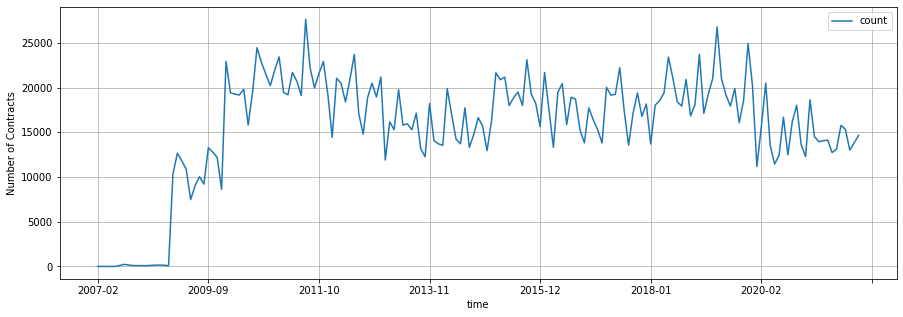

In [26]:
# Set mese-anno like index
# Show count of contract for each mese-anno
bal2 = bal1.groupby("mese-anno").size().reset_index(name='count')
bal2 = bal2.set_index('mese-anno')
f, ax1 = plt.subplots(1,1,figsize=(15,5))
bal2.plot(ax=ax1)
ax1.set_xlabel("time")
ax1.set_ylabel("Number of Contracts")
plt.grid(True)

In [27]:
# Calculate the Augmented Dickey-Fuller test can be used to test for a unit root in a univariate 
#process in the presence of serial correlation.
results = adfuller(bal2['count'])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -4.621934
p-value: 0.000118


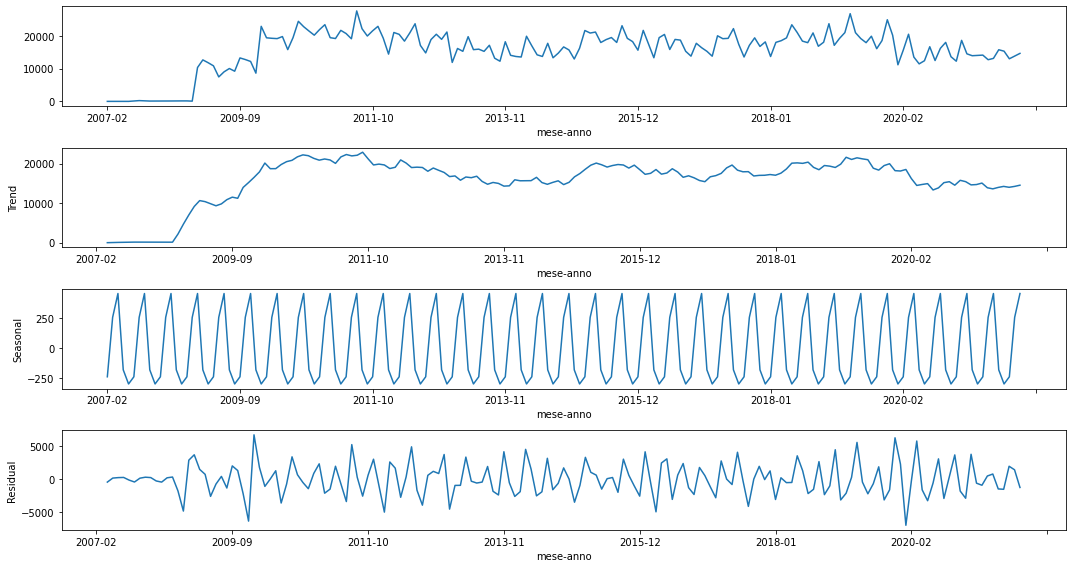

In [28]:
# Show seasonality and trend
plt.rcParams['figure.figsize'] = 20, 10
# Additive decomposition
decomposed_add = seasonal_decompose(bal2, model="additive", period=5)

fig, ax = plt.subplots(4, 1, figsize=(15, 8))
# Plot the series
decomposed_add.observed.plot(ax = ax[0])
decomposed_add.trend.plot(ax = ax[1])
decomposed_add.seasonal.plot(ax = ax[2])
decomposed_add.resid.plot(ax = ax[3])
# Add the labels to the Y-axis
ax[0].set_ylabel('')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

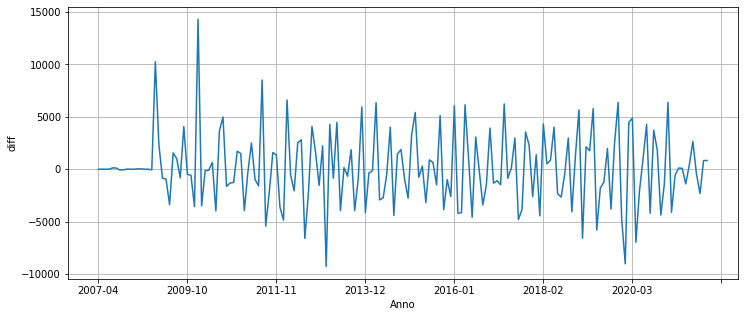

In [29]:
# Calculate differential
bal_diff = bal2['count'].diff().dropna()
plt.figure(figsize=(12,5))
ax1 = bal_diff.plot()
ax1.set_xlabel("Anno")
ax1.set_ylabel("diff")
plt.grid(True)
plt.show()

In [30]:
# Calculate the Augmented Dickey-Fuller test

results = adfuller(bal_diff)
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -2.966888
p-value: 0.038105


In [31]:
# Calculate the Augmented Dickey-Fuller test
results = adfuller(bal2['count'].diff().diff().dropna())
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

ADF Statistic: -7.803319
P-value of a test is: 7.393489604572998e-12


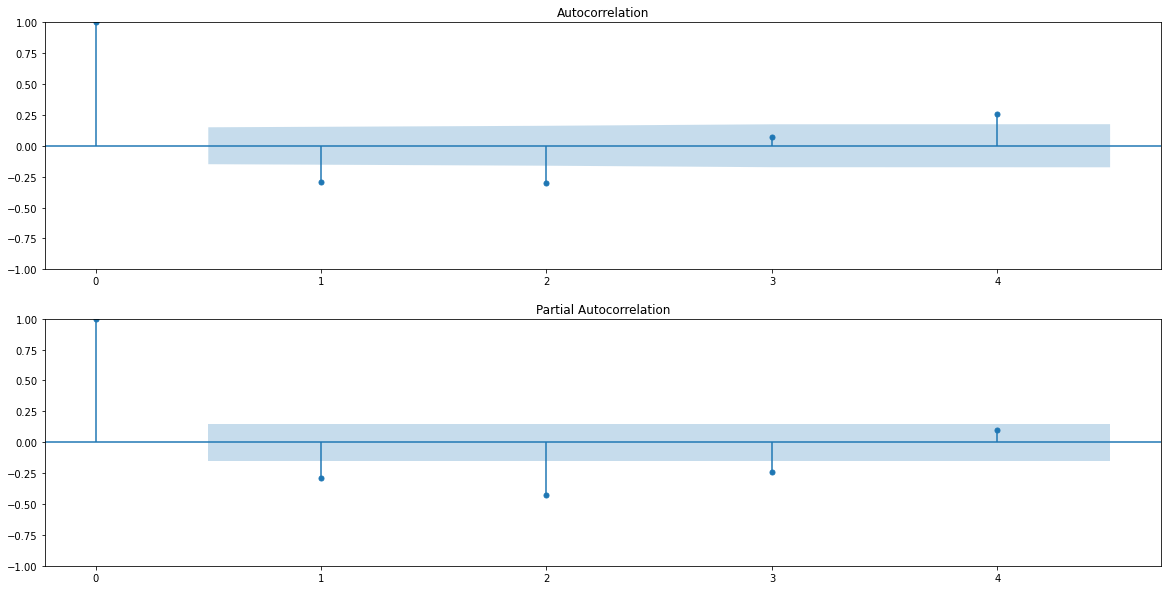

In [32]:
# Show autocorrelation and partial correlation
fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(bal_diff, lags=4, ax=ax[0])
plot_pacf(bal_diff, lags=4, ax=ax[1])
plt.show()

In [33]:
# Search p and q values

arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

i=0
# Loop over p values from 0-5
for p in range(4):
    # Loop over q values from 0-5
    for q in range(4):
        
        try:
            # creating and fitting ARIMA(p,1,q) model
            model = ARIMA(bal2['count'].astype(float), order=(p,1,q))
            results = model.fit()
            
            # Printing order, AIC and BIC
            #print(p, q, results.aic, results.bic)
            arima_df.loc[i,"p"] = p
            arima_df.loc[i,"q"] = q
            arima_df.loc[i,"aic"] = results.aic
            arima_df.loc[i,"bic"] = results.bic
            i = i+1
        except:
            #print(p, q, None, None)
            i = i+1
    
arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
arima_df.sort_values(by="aic", ascending=False, inplace=True)
arima_df

,p,q,aic,bic,sum_aic_bic


Best AIC value with p=3 and q=3

In [34]:
# Compute the model
model2 = SARIMAX(bal2, order=(3,1,3), seasonal_order=(0,1,0,6))
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              count   No. Observations:                  173
Model:             SARIMAX(3, 1, 3)x(0, 1, [], 6)   Log Likelihood               -1594.211
Date:                            Fri, 20 May 2022   AIC                           3202.422
Time:                                    14:56:32   BIC                           3224.206
Sample:                                         0   HQIC                          3211.264
                                            - 173                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6117      0.133     -4.591      0.000      -0.873      -0.351
ar.L2         -0.8416      0.103     -8.144      0.000      -1.044      -0.639
ar.L3         -0.1047      0.125     -0.835      0.404      -0.350       0.141
ma.L1          0.1415      0.086      1.637      0.102      -0.028       0.311
ma.L2          0.2026      0.078      2.602      0.009       0.050       0.355
ma.L3         -0.7853      0.082     -9.592      0.000      -0.946      -0.625
sigma2      1.564e+07   1.48e-09   1.05e+16      0.000    1.56e+07    1.56e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.20
Prob(Q):                              0.82   Prob(JB):                         0.33
Heteroskedasticity (H):               0.79   Skew:                             0.08
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.19e+32. Standard errors may be unstable.
"""

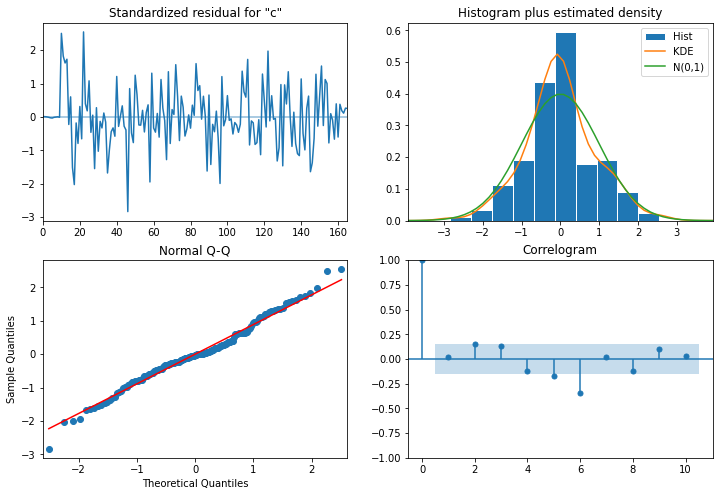

In [35]:
# Show ---
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()

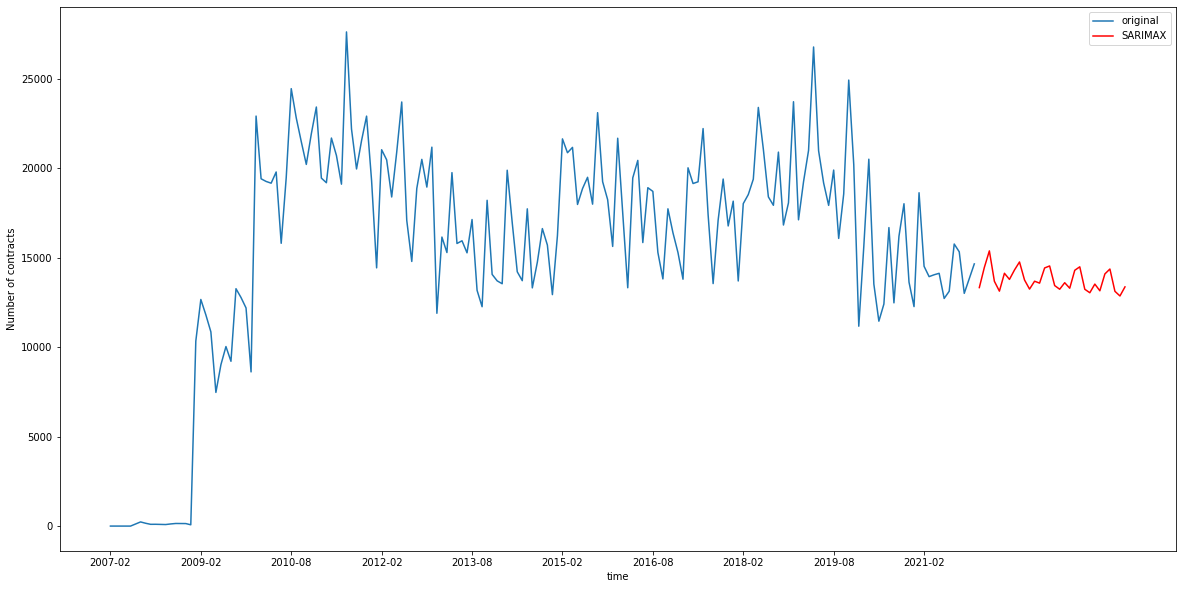

In [36]:
# Prediction of the future

# Create SARIMA mean forecast
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(bal2, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")

plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)

plt.xlabel('time')
plt.ylabel('Number of contracts')
plt.legend()
plt.show()

## Model Validation

### Featuring engineering

In [37]:
# Featuring engineering
# Lag features and Shift index
for i in range(1,3):
    lag_i = 'lag_' + str(i)
    bal2[lag_i] = bal2['count'].shift(i)
    
# Rolling window
bal2['rolling_mean'] = bal2['count'].rolling(window=2).mean()
bal2['rolling_max'] = bal2['count'].rolling(window=2).max()
bal2['rolling_min'] = bal2['count'].rolling(window=2).min()

### Correlation Feature

<AxesSubplot:>

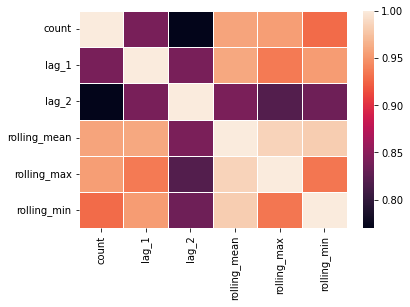

In [38]:
corr = bal2.corr()
fig = plt.figure(figsize=(6,4))
sns.heatmap(corr, linewidths=.5)

In [39]:
# Inference: count is less correlated with lag_1 and lag_2. Hence removing them from dataset.
bal2 = bal2[["rolling_mean","rolling_max", "rolling_min", "count"]]
print('Shape:', bal2.shape)
bal2.head()

Shape: (173, 4)


,rolling_mean,rolling_max,rolling_min,count
mese-anno,,,,
2007-02,NaN,NaN,NaN,2
2007-04,1.5,2.0,1.0,1
2007-06,1.0,1.0,1.0,1
2007-10,1.0,1.0,1.0,1
2007-11,1.0,1.0,1.0,1


In [40]:
# Fill NaN values with mean value
bal2.fillna(bal2.mean(), inplace = True)
bal2.head()

,rolling_mean,rolling_max,rolling_min,count
mese-anno,,,,
2007-02,15677.985465,16997.05814,14358.912791,2
2007-04,1.500000,2.00000,1.000000,1
2007-06,1.000000,1.00000,1.000000,1
2007-10,1.000000,1.00000,1.000000,1
2007-11,1.000000,1.00000,1.000000,1


In [41]:
# Show the dimension of the dataset to calculate the train and the test
bal2.shape

(173, 4)

In [42]:
# Split the time series data (Train-80, Test-20)
print('Total records in dataset:', len(bal2))
contract_train = bal2.iloc[0:138]               
contract_test = bal2.iloc[138:]

contract_pred_train = bal2.iloc[0:138]               
contract_pred_test = bal2.iloc[138:]
print('Total records in Training set:', len(contract_train))
print('Total records in Test set:', len(contract_test))

Total records in dataset: 173
Total records in Training set: 138
Total records in Test set: 35


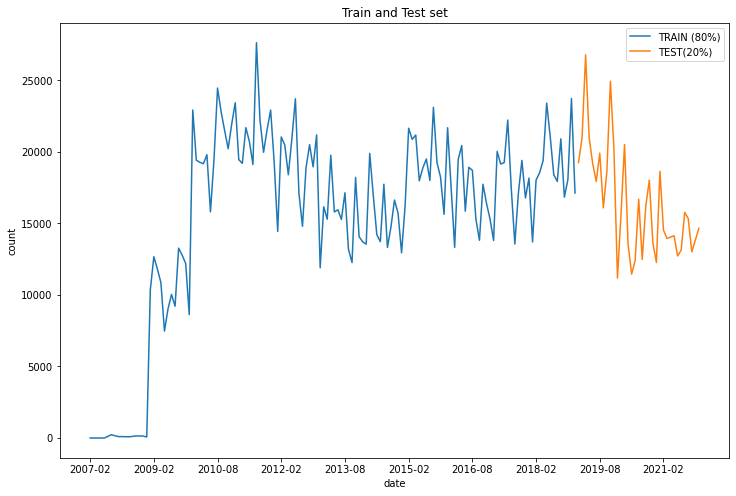

In [43]:
# Plot train and test sets
plt.plot(contract_train['count'],label='TRAIN (80%)')
plt.plot(contract_test['count'], label='TEST(20%)')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('count')
plt.title('Train and Test set')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

In [44]:
# Delete the feature to predict
X_train = contract_train.drop(['count'], axis=1)
y_train = contract_train['count'].values

X_test = contract_test.drop(['count'], axis=1)
y_test = contract_test['count'].values

In [45]:
# Delete the feature to predict
X_pred_train = contract_pred_train.drop(['count'], axis=1)
y_pred_train = contract_pred_train['count'].values

X_pred_test = contract_pred_test.drop(['count'], axis=1)
y_pred_test = contract_pred_test['count'].values

### Holt winter

Holt-Winters forecasting is a way to model and predict the behavior of a sequence of values over time—a time series.
Holt-Winters is a way to model three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality).

In [46]:
# Modeling the simple exponential smoothing
ses_model = SimpleExpSmoothing(contract_train['count']).fit(smoothing_level=0.3)
ses_preds = ses_model.forecast(steps = 35) 

In [47]:
# Calculate the errors
ses_errors_df = contract_test[['count']]
ses_errors_df['Predicted_Count'] = ses_preds.values
ses_errors_df['Error'] = ses_preds.values - y_test
ses_errors_df.insert(0, 'Modelname', 'Holtman- SES')

In [48]:
# Modeling the double exponential smoothing
double_model = ExponentialSmoothing(contract_train['count'],trend='add').fit()
doublemodel_preds = double_model.forecast(35).rename('DES Forecast')

In [49]:
# Calculate the errors
des_errors_df = contract_test[['count']]
des_errors_df['Predicted_Count'] = doublemodel_preds.values
des_errors_df['Error'] = doublemodel_preds.values - y_test
des_errors_df.insert(0, 'Modelname', 'Holtman- DES')
des_errors_df.head()

,Modelname,count,Predicted_Count,Error
mese-anno,,,,
2019-02,Holtman- DES,19251,19209.132077,-41.867923
2019-03,Holtman- DES,21004,19230.197535,-1773.802465
2019-04,Holtman- DES,26785,19251.262992,-7533.737008
2019-05,Holtman- DES,20982,19272.328450,-1709.671550
2019-06,Holtman- DES,19182,19293.393908,111.393908


In [50]:
# Modeling the triple exponential smoothing
triple_model = ExponentialSmoothing(contract_train['count'],trend='add', seasonal= 'mul',seasonal_periods= 12).fit(use_boxcox=False, remove_bias=False)
tes_forecast = triple_model.forecast(35).rename('TES_Forecast')

ValueError: use_boxcox was set at model initialization and cannot be changed

In [ ]:
# Calculate the errors
tes_errors_df = contract_test[['count']]
tes_errors_df['Predicted_Count'] = tes_forecast.values
tes_errors_df['Error'] = tes_forecast.values - y_test
tes_errors_df.insert(0, 'Modelname', 'Holtman- TES')
tes_errors_df.head()

In [ ]:
# Plot the number of contract using holtman forecast model using Double Exponential Smoothing
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(des_errors_df.index, des_errors_df['Predicted_Count'], label='Forecast - HW-DES')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('count')
plt.title('Forecast using Holt Winters-Double Exponential Smoothing')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

In [ ]:
# Plot the number of contract using holtman forecast model using Triple Exponential Smoothing
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(tes_errors_df.index, tes_errors_df['Predicted_Count'], label='Forecast - HW-TES')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('count')
plt.title('Forecast using Holt Winters-Triple Exponential Smoothing')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### Extra trees regressor

* Composed of a large number of decision trees, where the final decision is obtained taking into account the prediction of every tree
* When selecting the partition of each node, randomly choose a subset of features

In [ ]:
# Fit model
etr_model = ExtraTreesRegressor(n_estimators=100)
etr_model.fit(X_train, y_train)

In [ ]:
# Start the prediction
etr_preds = etr_model.predict(X_test)
print('Prediction is done..')

In [ ]:
# Check the score for the train and test sets
print('Model Score at Train set: {:.2%}'.format(etr_model.score(X_train, y_train)))
print('Model Score at Test set: {:.2%}'.format(etr_model.score(X_test, y_test)))

In [ ]:
# Calculate the errors
etr_errors_df = contract_test[['count']]
etr_errors_df['Predicted_Count'] = etr_preds
etr_errors_df['Error'] = etr_preds - y_test
etr_errors_df.insert(0, 'Modelname', 'ExtreeTreesRegressor')
etr_errors_df.head()

In [ ]:
# Show the predictions for Extra Tree Regressor
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(etr_errors_df.index, etr_errors_df['Predicted_Count'], label='Forecast - ExtraTreesRegressor')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('count')
plt.title('Forecast using ExtraTreesRegressor model')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### Linear regression

Model for understanding the relationship between input and output numerical variables. 

In [ ]:
# Fit model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

In [ ]:
# Start the prediction
lr_preds = lr_model.predict(X_test)
print('Prediction is done..')

In [ ]:
# Calculate the errors
lr_errors_df = contract_test[['count']]
lr_errors_df['Predicted_Count'] = lr_preds
lr_errors_df['Error'] = lr_preds - y_test
lr_errors_df.insert(0, 'Modelname', 'Linear Regression')
lr_errors_df.head()

In [ ]:
# Show the predictions for Linear Regression
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(lr_errors_df.index, lr_errors_df['Predicted_Count'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('count')
plt.title('Forecast using Linear Regression')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### ARIMA e SARIMAX

In [ ]:
# Fit the model
arima_model = ARIMA(bal2['count'], (3,1,3)).fit(disp=False)
print(arima_model.summary())

In [ ]:
# Fit the model
sarima_model = SARIMAX(bal2['count'], order=(3, 1, 3), seasonal_order=(6, 1, 0, 6), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
sarima_test_df = contract_test[["count"]]
sarima_test_df['Predicted_Count'] = sarima_fit.predict(start=contract_test.index[0],
                                                 end=contract_test.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

In [ ]:
# Evaluation of errors
sarima_test_df['Error'] = sarima_test_df['count'] - sarima_test_df.Predicted_Count
sarima_test_df.insert(0, 'Modelname', 'SARIMA')
sarima_test_df.head()

In [ ]:
# Show the predictions for SARIMA model
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(sarima_test_df.index, sarima_test_df['Predicted_Count'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('count')
plt.title('Forecast using SARIMA')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

In [ ]:
# Show the errors for the predicted and the actual values
plt.figure(figsize=(14,7))
plt.plot(sarima_test_df.index, np.abs(sarima_test_df['Error']), label='errors')
plt.plot(sarima_test_df.index, sarima_test_df['count'], label='Actual Count')
plt.plot(sarima_test_df.index, sarima_test_df['Predicted_Count'], label='Predicted Count')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual count vs errors')
plt.xticks(sarima_test_df.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### SVR (Support Vector Regressor)  regressor

Regression model that gives  the flexibility to define how much error is acceptable in our model and will find an appropriate line to fit the data.

In [ ]:
# Start the prediction
import sklearn
svr_model = sklearn.svm.SVR(kernel='linear', degree=3, C=1.0,).fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)
print('Prediction is done...')

# Errors calculation
svr_errors_df = contract_test[['count']]
svr_errors_df['Predicted_Count'] = svr_preds
svr_errors_df['Error'] = svr_preds - y_test
svr_errors_df.insert(0, 'Modelname', 'Support Vector Regressor')
svr_errors_df.head()

In [ ]:
# Show predictions for Support Vector Regressor
fig = plt.figure(figsize=(14,7))
plt.plot(contract_train.index, contract_train['count'], label='Train')
plt.plot(contract_test.index, contract_test['count'], label='Test')
plt.plot(svr_errors_df.index, svr_errors_df['Predicted_Count'], label='Forecast - Support Vector Regressor')
plt.legend(loc='best')
plt.xlabel('Intervals')
plt.ylabel('Count')
plt.title('Forecast using Support Vector Regressor')
plt.xticks(bal2.index.unique())
plt.locator_params(axis='x', nbins=10)
plt.show()

### Compare the different models

To compare the models, we use:
* MAE: Mean Absolute Error is the average over the verification sample of the absolute values of the differences between forecast and the corresponding observation.
* RMSE: Root Mean Squared Error is the square root of the mean of the square of all of the error.
* MAPE: Mean Absolute Percentage Error is a measure of prediction accuracy of a forecasting method in statistics.

In [ ]:
# Define metrics

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, count=tes_errors_df['count']):
    return np.sum(np.abs(err))/np.sum(count) * 100

In [ ]:
# Calculate metrics for SVR
result_df_svr = svr_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_svr

In [ ]:
# Calculate metrics for SARIMA
result_df_sarima = sarima_test_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_sarima

In [ ]:
# Calculate metrics for Holtman Winter
result_df_hw = tes_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_hw

In [ ]:
# Calculate metrics for Linear regression
result_df_lr = lr_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_lr

In [ ]:
# Calculate metrics for Extra tree regression
result_df_etr = etr_errors_df.groupby('Modelname').agg(Total_Count=('count', 'sum'),
                                          Total_Pred_Count=('Predicted_Count', 'sum'),
                                          Model_Overall_Error=('Error', 'sum'),
                                          MAE=('Error', mae),
                                          RMSE=('Error', rmse), 
                                          MAPE=('Error', mape))
result_df_etr

In [ ]:
# Create the table with all the previous calculated results
list_objs = [result_df_svr, result_df_lr, result_df_hw, result_df_sarima, result_df_etr]
metrics_table = pd.concat(list_objs)
metrics_table

In [ ]:
# Check of the model
print('Model Score at Train set: {:.2%}'.format(etr_model.score(X_train, y_train)))
print('Model Score at Test set: {:.2%}'.format(etr_model.score(X_test, y_test)))

From above metrics the "Extra Trees Regressor" model performs well, but also the Linear Regressor. 
In addition model score is not pretty accurate with (100% for Train data, 64.02% for Test data).

In [ ]:
# Show Prediction of Extra Tree Regressor
etr_prediction = pd.DataFrame(data=etr_preds, columns=['Predicted_Count'])
contract_pred_test.drop(columns= ['rolling_mean','rolling_max','rolling_min'], inplace=True)
contract_pred_test.reset_index(inplace=True)
compare_results = pd.merge(contract_pred_test, etr_prediction, left_index=True, right_index=True)

In [ ]:
# Compare the predictions with the real values
compare_results=compare_results.drop(columns='mese-anno')
compare_results

## Pre COVID Prediction

In [ ]:
# Extract only the elements of the pre COVID years
pre_covid = transformed[transformed['ANNO']<2019]
pre_covid

### Balancing

In [ ]:
# Check if the dataset is balanced
pre_covid["contratto_transformed"].value_counts(normalize=True)

We notice that the dataset is not balanced basing on the type of contract

In [ ]:
# Count the occurencies of INDETERMINATO's contracts
pre_covid[pre_covid["contratto_transformed"]==1].count()

In [ ]:
# Count the occurencies of NON INDETERMINATO's contracts
pre_covid[pre_covid["contratto_transformed"]==0].count()

#### Random Undersampling

We use undersampling instead of oversampling because we care more about the INDETERMINATO's contracts which have less occurencies, even if there are the possibilities to lose some informations.

In [ ]:
# Execute the undersampling for the NON INDETERMINATO's contracts
data_0 = pre_covid[pre_covid["contratto_transformed"]==0].sample(n=1064553,random_state=16) 
data_1 = pre_covid[pre_covid["contratto_transformed"]==1]
balanced_pre = data_0.append(data_1)
balanced_pre

In [ ]:
# Check if the dataset is balanced
balanced_pre["contratto_transformed"].value_counts(normalize=True)

### Create the train and test sets

In [ ]:
# Create the train and test sets
X = balanced_pre[["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"]].values
y = pd.DataFrame(balanced_pre['Output_transformed'].copy()).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

In [ ]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
X_train=X_train.astype(np.uint8)
y_train=y_train.astype(np.uint8)

### Decision Tree

In [ ]:
# Define the Decision Tree
dct = tree.DecisionTreeClassifier()
DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=10,
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                           max_features=None, 
                           random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           class_weight=None)

In [ ]:
# Create Decision tree and fit it
dct.fit(X_train, y_train)

In [ ]:
# With the following sintax we will create a .dot file with the code for visualizing th tree
tree.export_graphviz(dct, out_file='tree.dot', feature_names=["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"])

In [ ]:
# Show Decision tree
tree.plot_tree(dct)

In [ ]:
# Probablistic prediction the values
y_pred_prob = dct.predict_proba(X_test)
y_pred_prob

In [ ]:
# Predict the values
y_pred = dct.predict(X_test)
y_pred

#### Confusion Matrix

In [ ]:
# To avoid the MemoryError, we change the dataset's type into a new lighter one
y_test=y_test.astype(np.uint8)
y_pred=y_pred.astype(np.uint8)

# Print the confusion matrix
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)

### ARIMA

Prediction of the number of activated contracts wiht Autoregressive integrated moving average model.

In [ ]:
# Load the dataset
balanced1 = balanced_pre.copy()
balanced1 = balanced1.reset_index(drop=True)
balanced1

In [ ]:
# Set mese-anno like index
# Show count of contract for each mese-anno
balanced2 = balanced1.groupby("mese-anno").size().reset_index(name='count')
balanced2 = balanced2.set_index('mese-anno')
f, ax1 = plt.subplots(1,1,figsize=(15,5))
balanced2.plot(ax=ax1)
ax1.set_xlabel("time")
ax1.set_ylabel("Number of Contracts")
plt.grid(True)

In [ ]:
# Calculate the Augmented Dickey-Fuller test can be used to test for a unit root in a univariate 
#process in the presence of serial correlation.
results = adfuller(balanced2['count'])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

In [ ]:
# Show seasonality and trend
plt.rcParams['figure.figsize'] = 20, 10
# Additive decomposition
decomposed_add = seasonal_decompose(balanced2, model="additive", period=5)

fig, ax = plt.subplots(4, 1, figsize=(15, 8))
# Plot the series
decomposed_add.observed.plot(ax = ax[0])
decomposed_add.trend.plot(ax = ax[1])
decomposed_add.seasonal.plot(ax = ax[2])
decomposed_add.resid.plot(ax = ax[3])
# Add the labels to the Y-axis
ax[0].set_ylabel('')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [ ]:
# Search p and q values

arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

i=0
# Loop over p values from 0-5
for p in range(4):
    # Loop over q values from 0-5
    for q in range(4):
        
        try:
            # creating and fitting ARIMA(p,1,q) model
            model = ARIMA(balanced2['count'].astype(float), order=(p,1,q))
            results = model.fit()
            
            # Printing order, AIC and BIC
            #print(p, q, results.aic, results.bic)
            arima_df.loc[i,"p"] = p
            arima_df.loc[i,"q"] = q
            arima_df.loc[i,"aic"] = results.aic
            arima_df.loc[i,"bic"] = results.bic
            i = i+1
        except:
            #print(p, q, None, None)
            i = i+1
    
arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
arima_df.sort_values(by="aic", ascending=False, inplace=True)
arima_df

In [ ]:
# Compute the model
model2 = SARIMAX(balanced2, order=(3,1,3), seasonal_order=(0,1,0,6))
results = model2.fit()
results.summary()

In [ ]:
# Show ---
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()

In [ ]:
# Prediction of the future

# Create SARIMA mean forecast
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(balanced2, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")

plt.xticks(balanced2.index.unique())
plt.locator_params(axis='x', nbins=10)

plt.xlabel('time')
plt.ylabel('Number of contracts')
plt.title('Pre-covid Situation')
plt.legend()
plt.show()

#### Pre vs Post COVID

In [ ]:
# Extract only the elements of the post COVID years
post_covid = transformed[transformed['ANNO']>=2019]
post_covid

##### Balancing

In [ ]:
# Check if the dataset is balanced
post_covid["contratto_transformed"].value_counts(normalize=True)

In [ ]:
# Count the occurencies of INDETERMINATO's contracts
post_covid[post_covid["contratto_transformed"]==1].count()

In [ ]:
# Count the occurencies of NON INDETERMINATO's contracts
post_covid[post_covid["contratto_transformed"]==0].count()

###### Random Undersampling

In [ ]:
# Execute the undersampling for the NON INDETERMINATO's contracts
data_0 = post_covid[post_covid["contratto_transformed"]==0].sample(n=287419,random_state=16) 
data_1 = post_covid[post_covid["contratto_transformed"]==1]
balanced_covid = data_0.append(data_1)
balanced_covid

In [ ]:
# Check if the dataset is balanced
balanced_covid["contratto_transformed"].value_counts(normalize=True)

##### Prediction

In [ ]:
# Set mese-anno like index
# Show count of contract for each mese-anno
balanced_covid1 = balanced_covid.groupby("mese-anno").size().reset_index(name='count')
balanced_covid1 = balanced_covid1.set_index('mese-anno')
f, ax1 = plt.subplots(1,1,figsize=(15,5))
balanced_covid1.plot(ax=ax1)
ax1.set_xlabel("time")
ax1.set_ylabel("Number of Contracts")

In [ ]:
# Create SARIMA mean forecast
forecast = results.get_forecast(steps=30)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(balanced2, label='Real values before COVID')
plt.plot(forecast.predicted_mean, label='SARIMAX prediction', c="r")
plt.plot(balanced_covid1, label='Real values after COVID', c='g')
plt.xticks(balanced2.index.unique())
plt.locator_params(axis='x', nbins=10)

plt.xlabel('time')
plt.ylabel('Number of contracts')
plt.title('COVID Situation (Checking)')
plt.legend()
plt.show()

#### Results

As we can see in the graph, the COVID situation led to decrease in the number of contracts, compared to the prediction based on data through 2019. 